# **Statistical Validation**
Tests: DeLong, Bootstrap CI, McNemar, Permutation, Cohen's d

Compares baseline vs our models with proper significance testing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime

## **DELONG TEST IMPLEMENTATION**

In [ ]:
def delong_test(y_true, y_pred1, y_pred2):
    """
    DeLong test for comparing two ROC curves
    Returns: z-statistic, p-value, AUC difference
    """
    from sklearn.metrics import roc_auc_score

    auc1 = roc_auc_score(y_true, y_pred1)
    auc2 = roc_auc_score(y_true, y_pred2)

    n1 = np.sum(y_true == 1)
    n0 = np.sum(y_true == 0)

    #ranks for positive class
    order1 = np.argsort(y_pred1)
    ranks1 = np.empty_like(order1)
    ranks1[order1] = np.arange(len(y_pred1))

    order2 = np.argsort(y_pred2)
    ranks2 = np.empty_like(order2)
    ranks2[order2] = np.arange(len(y_pred2))

    #calculate variances (simplified)
    V10 = (auc1 * (1 - auc1) + (n1 - 1) * (auc1 / (2 - auc1) - auc1**2) +
           (n0 - 1) * (2 * auc1**2 / (1 + auc1) - auc1**2)) / (n1 * n0)

    V20 = (auc2 * (1 - auc2) + (n1 - 1) * (auc2 / (2 - auc2) - auc2**2) +
           (n0 - 1) * (2 * auc2**2 / (1 + auc2) - auc2**2)) / (n1 * n0)

    #covariance (approximation)
    V12 = (V10 + V20) / 2

    #Z-statistic
    z = (auc1 - auc2) / np.sqrt(V10 + V20 - 2 * V12)
    p_value = 2 * (1 - norm.cdf(abs(z)))

    return z, p_value, auc1 - auc2

## **BOOTSTRAP CONFIDENCE INTERVALS**

In [ ]:
def bootstrap_auc_ci(y_true, y_pred, n_iterations=1000, confidence=0.95):
    """
    Bootstrap confidence intervals for AUC
    Returns: (lower_bound, upper_bound, mean_auc)
    """
    np.random.seed(42)
    aucs = []
    n_samples = len(y_true)

    for i in range(n_iterations):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue
        auc = roc_auc_score(y_true[indices], y_pred[indices])
        aucs.append(auc)

    aucs = np.array(aucs)
    alpha = 1 - confidence
    lower = np.percentile(aucs, alpha/2 * 100)
    upper = np.percentile(aucs, (1 - alpha/2) * 100)

    return lower, upper, np.mean(aucs)

## **MCNEMAR TEST**

In [ ]:
def mcnemar_test(y_true, y_pred1, y_pred2):
    """
    McNemar test for comparing classifier predictions
    Returns: statistic, p-value
    """
    #convert probabilities to binary predictions
    pred1_binary = (y_pred1 > 0.5).astype(int)
    pred2_binary = (y_pred2 > 0.5).astype(int)

    #create contingency table
    both_correct = np.sum((pred1_binary == y_true) & (pred2_binary == y_true))
    only_1_correct = np.sum((pred1_binary == y_true) & (pred2_binary != y_true))
    only_2_correct = np.sum((pred1_binary != y_true) & (pred2_binary == y_true))
    both_wrong = np.sum((pred1_binary != y_true) & (pred2_binary != y_true))

    #McNemar statistic (with continuity correction)
    if only_1_correct + only_2_correct == 0:
        return 0, 1.0

    statistic = (abs(only_1_correct - only_2_correct) - 1)**2 / (only_1_correct + only_2_correct)
    p_value = 1 - stats.chi2.cdf(statistic, df=1)

    return statistic, p_value

## **COHEN'S D EFFECT SIZE**

In [ ]:
def cohens_d(auc1, auc2, n1, n2):
    """
    Cohen's d effect size for AUC difference
    Returns: effect size, interpretation
    """
    #approximate pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * 0.1**2 + (n2 - 1) * 0.1**2) / (n1 + n2 - 2))
    d = (auc1 - auc2) / pooled_std

    if abs(d) < 0.2:
        interpretation = "negligible"
    elif abs(d) < 0.5:
        interpretation = "small"
    elif abs(d) < 0.8:
        interpretation = "medium"
    else:
        interpretation = "large"

    return d, interpretation

## **PERMUTATION TEST**

In [ ]:
def permutation_test(y_true, y_pred1, y_pred2, n_permutations=1000):
    """
    Permutation test for AUC difference
    Returns: p-value
    """
    auc1 = roc_auc_score(y_true, y_pred1)
    auc2 = roc_auc_score(y_true, y_pred2)
    observed_diff = auc1 - auc2

    np.random.seed(42)
    perm_diffs = []

    for _ in range(n_permutations):
        #randomly swap predictions
        mask = np.random.rand(len(y_pred1)) > 0.5
        perm_pred1 = np.where(mask, y_pred1, y_pred2)
        perm_pred2 = np.where(mask, y_pred2, y_pred1)

        perm_auc1 = roc_auc_score(y_true, perm_pred1)
        perm_auc2 = roc_auc_score(y_true, perm_pred2)
        perm_diffs.append(perm_auc1 - perm_auc2)

    p_value = np.sum(np.abs(perm_diffs) >= abs(observed_diff)) / n_permutations
    return p_value

## **LOAD DATA**

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ML-iAMR_Recreation/01_data/raw/giessen/cip_ctx_ctz_gen_multi_data.csv")
pheno = pd.read_csv("/content/drive/MyDrive/ML-iAMR_Recreation/01_data/raw/giessen/cip_ctx_ctz_gen_pheno.csv", index_col=0)
X = data.drop('prename', axis=1).values

In [ ]:
EXPERIMENT_ID = f"EXP-009-{datetime.now().strftime('%Y%m%d_%H%M%S')}"
print(f"Experiment: {EXPERIMENT_ID}")

Experiment: EXP-009-20251107_091000


## **RUN STATISTICAL TESTS**

In [ ]:
all_results = []

#define models (load optimized params from EXP-006)
BASELINE_PARAMS = {'n_estimators': 200, 'random_state': 42, 'n_jobs': -1}

#using enhanced params
ENHANCED_PARAMS = {
    'CTZ': {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 5,
            'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1},
    'GEN': {'n_estimators': 400, 'max_depth': 25, 'min_samples_split': 3,
            'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}
}

In [ ]:
for ab in ['CIP', 'CTX', 'CTZ', 'GEN']:

    print(f"STATISTICAL VALIDATION FOR {ab}")


    y = pheno[ab].values

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    baseline_preds = []
    enhanced_preds = []
    y_true_all = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        #baseline model
        rf_baseline = RandomForestClassifier(**BASELINE_PARAMS)
        rf_baseline.fit(X_train, y_train)
        pred_baseline = rf_baseline.predict_proba(X_val)[:, 1]

        #Enhanced model
        if ab in ['CTZ', 'GEN']:
            rf_enhanced = RandomForestClassifier(**ENHANCED_PARAMS[ab])
        else:
            #for CIP/CTX, use ensemble weights as "enhancement"
            rf_enhanced = RandomForestClassifier(**BASELINE_PARAMS)

        rf_enhanced.fit(X_train, y_train)
        pred_enhanced = rf_enhanced.predict_proba(X_val)[:, 1]

        baseline_preds.extend(pred_baseline)
        enhanced_preds.extend(pred_enhanced)
        y_true_all.extend(y_val)

    baseline_preds = np.array(baseline_preds)
    enhanced_preds = np.array(enhanced_preds)
    y_true_all = np.array(y_true_all)

    #calculate AUCs
    auc_baseline = roc_auc_score(y_true_all, baseline_preds)
    auc_enhanced = roc_auc_score(y_true_all, enhanced_preds)

    print(f"\nBaseline AUC: {auc_baseline:.4f}")
    print(f"Enhanced AUC: {auc_enhanced:.4f}")
    print(f"Difference:   {auc_enhanced - auc_baseline:+.4f}")

STATISTICAL VALIDATION FOR CIP

Baseline AUC: 0.9528
Enhanced AUC: 0.9528
Difference:   +0.0000
STATISTICAL VALIDATION FOR CTX

Baseline AUC: 0.8406
Enhanced AUC: 0.8406
Difference:   +0.0000
STATISTICAL VALIDATION FOR CTZ

Baseline AUC: 0.8442
Enhanced AUC: 0.8451
Difference:   +0.0008
STATISTICAL VALIDATION FOR GEN

Baseline AUC: 0.7670
Enhanced AUC: 0.7856
Difference:   +0.0186


In [ ]:
for ab in ['CIP', 'CTX', 'CTZ', 'GEN']:

    print(f"STATISTICAL VALIDATION FOR {ab}")


    y = pheno[ab].values

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    baseline_preds = []
    enhanced_preds = []
    y_true_all = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        #baseline model
        rf_baseline = RandomForestClassifier(**BASELINE_PARAMS)
        rf_baseline.fit(X_train, y_train)
        pred_baseline = rf_baseline.predict_proba(X_val)[:, 1]

        #Enhanced model
        if ab in ['CTZ', 'GEN']:
            rf_enhanced = RandomForestClassifier(**ENHANCED_PARAMS[ab])
        else:
            #for CIP/CTX, use ensemble weights as "enhancement"
            rf_enhanced = RandomForestClassifier(**BASELINE_PARAMS)

        rf_enhanced.fit(X_train, y_train)
        pred_enhanced = rf_enhanced.predict_proba(X_val)[:, 1]

        baseline_preds.extend(pred_baseline)
        enhanced_preds.extend(pred_enhanced)
        y_true_all.extend(y_val)

    baseline_preds = np.array(baseline_preds)
    enhanced_preds = np.array(enhanced_preds)
    y_true_all = np.array(y_true_all)

    #calculate AUCs
    auc_baseline = roc_auc_score(y_true_all, baseline_preds)
    auc_enhanced = roc_auc_score(y_true_all, enhanced_preds)

    print(f"\nBaseline AUC: {auc_baseline:.4f}")
    print(f"Enhanced AUC: {auc_enhanced:.4f}")
    print(f"Difference:   {auc_enhanced - auc_baseline:+.4f}")

    #DeLong Test
    print(f"\n--- DeLong Test ---")
    z_stat, p_delong, auc_diff = delong_test(y_true_all, baseline_preds, enhanced_preds)
    print(f"Z-statistic: {z_stat:.4f}")
    print(f"P-value: {p_delong:.4f}")
    print(f"Significance: {'Significant (p < 0.05)' if p_delong < 0.05 else 'Not significant'}")

    #Bootstrap CI
    print(f"\n--- Bootstrap Confidence Intervals (95%) ---")
    lower_base, upper_base, _ = bootstrap_auc_ci(y_true_all, baseline_preds)
    lower_enh, upper_enh, _ = bootstrap_auc_ci(y_true_all, enhanced_preds)
    print(f"Baseline: [{lower_base:.4f}, {upper_base:.4f}]")
    print(f"Enhanced: [{lower_enh:.4f}, {upper_enh:.4f}]")
    print(f"Overlap: {'No (significant difference)' if upper_base < lower_enh or upper_enh < lower_base else 'Yes (overlapping)'}")

    #McNemar Test
    print(f"\n--- McNemar Test ---")
    mcnemar_stat, p_mcnemar = mcnemar_test(y_true_all, baseline_preds, enhanced_preds)
    print(f"Statistic: {mcnemar_stat:.4f}")
    print(f"P-value: {p_mcnemar:.4f}")
    print(f"Significance: {'Significant (p < 0.05)' if p_mcnemar < 0.05 else 'Not significant'}")

    #Cohen's d
    print(f"\n--- Effect Size (Cohen's d) ---")
    d, interpretation = cohens_d(auc_enhanced, auc_baseline, len(y_true_all), len(y_true_all))
    print(f"Cohen's d: {d:.4f}")
    print(f"Interpretation: {interpretation}")

    #permutation Test
    print(f"\n--- Permutation Test ---")
    p_perm = permutation_test(y_true_all, baseline_preds, enhanced_preds, n_permutations=1000)
    print(f"P-value: {p_perm:.4f}")
    print(f"Significance: {'Significant (p < 0.05)' if p_perm < 0.05 else 'Not significant'}")

    #tore results
    result = {
        'Experiment_ID': EXPERIMENT_ID,
        'Antibiotic': ab,
        'AUC_Baseline': round(auc_baseline, 4),
        'AUC_Enhanced': round(auc_enhanced, 4),
        'AUC_Difference': round(auc_enhanced - auc_baseline, 4),
        'DeLong_Z': round(z_stat, 4),
        'DeLong_P': round(p_delong, 4),
        'Bootstrap_CI_Base': f"[{lower_base:.4f}, {upper_base:.4f}]",
        'Bootstrap_CI_Enh': f"[{lower_enh:.4f}, {upper_enh:.4f}]",
        'McNemar_Stat': round(mcnemar_stat, 4),
        'McNemar_P': round(p_mcnemar, 4),
        'Cohens_d': round(d, 4),
        'Effect_Size': interpretation,
        'Permutation_P': round(p_perm, 4),
        'Significant': p_delong < 0.05 or p_perm < 0.05
    }
    all_results.append(result)

STATISTICAL VALIDATION FOR CIP

Baseline AUC: 0.9528
Enhanced AUC: 0.9528
Difference:   +0.0000

--- DeLong Test ---
Z-statistic: nan
P-value: nan
Significance: Not significant

--- Bootstrap Confidence Intervals (95%) ---


/tmp/ipython-input-3115584837.py:34: RuntimeWarning: invalid value encountered in scalar divide
  z = (auc1 - auc2) / np.sqrt(V10 + V20 - 2 * V12)


Baseline: [0.9380, 0.9662]
Enhanced: [0.9380, 0.9662]
Overlap: Yes (overlapping)

--- McNemar Test ---
Statistic: 0.0000
P-value: 1.0000
Significance: Not significant

--- Effect Size (Cohen's d) ---
Cohen's d: 0.0000
Interpretation: negligible

--- Permutation Test ---
P-value: 1.0000
Significance: Not significant
STATISTICAL VALIDATION FOR CTX

Baseline AUC: 0.8406
Enhanced AUC: 0.8406
Difference:   +0.0000

--- DeLong Test ---
Z-statistic: nan
P-value: nan
Significance: Not significant

--- Bootstrap Confidence Intervals (95%) ---


/tmp/ipython-input-3115584837.py:34: RuntimeWarning: invalid value encountered in scalar divide
  z = (auc1 - auc2) / np.sqrt(V10 + V20 - 2 * V12)


Baseline: [0.8120, 0.8667]
Enhanced: [0.8120, 0.8667]
Overlap: Yes (overlapping)

--- McNemar Test ---
Statistic: 0.0000
P-value: 1.0000
Significance: Not significant

--- Effect Size (Cohen's d) ---
Cohen's d: 0.0000
Interpretation: negligible

--- Permutation Test ---
P-value: 1.0000
Significance: Not significant
STATISTICAL VALIDATION FOR CTZ

Baseline AUC: 0.8442
Enhanced AUC: 0.8451
Difference:   +0.0008

--- DeLong Test ---
Z-statistic: -inf
P-value: 0.0000
Significance: Significant (p < 0.05)

--- Bootstrap Confidence Intervals (95%) ---


/tmp/ipython-input-3115584837.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  z = (auc1 - auc2) / np.sqrt(V10 + V20 - 2 * V12)


Baseline: [0.8149, 0.8740]
Enhanced: [0.8151, 0.8751]
Overlap: Yes (overlapping)

--- McNemar Test ---
Statistic: 2.7826
P-value: 0.0953
Significance: Not significant

--- Effect Size (Cohen's d) ---
Cohen's d: 0.0084
Interpretation: negligible

--- Permutation Test ---
P-value: 0.8170
Significance: Not significant
STATISTICAL VALIDATION FOR GEN

Baseline AUC: 0.7670
Enhanced AUC: 0.7856
Difference:   +0.0186

--- DeLong Test ---
Z-statistic: -inf
P-value: 0.0000
Significance: Significant (p < 0.05)

--- Bootstrap Confidence Intervals (95%) ---


/tmp/ipython-input-3115584837.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  z = (auc1 - auc2) / np.sqrt(V10 + V20 - 2 * V12)


Baseline: [0.7326, 0.8004]
Enhanced: [0.7515, 0.8188]
Overlap: Yes (overlapping)

--- McNemar Test ---
Statistic: 0.3125
P-value: 0.5762
Significance: Not significant

--- Effect Size (Cohen's d) ---
Cohen's d: 0.1860
Interpretation: negligible

--- Permutation Test ---
P-value: 0.0280
Significance: Significant (p < 0.05)


## **SAVE RESULTS**

In [ ]:
results_df = pd.DataFrame(all_results)

print("STATISTICAL VALIDATION SUMMARY")

print(results_df[['Antibiotic', 'AUC_Baseline', 'AUC_Enhanced', 'AUC_Difference',
                   'DeLong_P', 'Cohens_d', 'Effect_Size', 'Significant']].to_string(index=False))

results_df.to_csv(f"/content/drive/MyDrive/ML-iAMR_Recreation/05_evaluation/results/{EXPERIMENT_ID}_statistical_tests.csv", index=False)
print(f"\nFull results saved to results/{EXPERIMENT_ID}_statistical_tests.csv")

STATISTICAL VALIDATION SUMMARY
Antibiotic  AUC_Baseline  AUC_Enhanced  AUC_Difference  DeLong_P  Cohens_d Effect_Size  Significant
       CIP        0.9528        0.9528          0.0000       NaN    0.0000  negligible        False
       CTX        0.8406        0.8406          0.0000       NaN    0.0000  negligible        False
       CTZ        0.8442        0.8451          0.0008       0.0    0.0084  negligible         True
       GEN        0.7670        0.7856          0.0186       0.0    0.1860  negligible         True

Full results saved to results/EXP-009-20251107_091000_statistical_tests.csv


## **VISUALIZATION**

ROC curves saved: EXP-009-20251107_091000_roc_curves.png


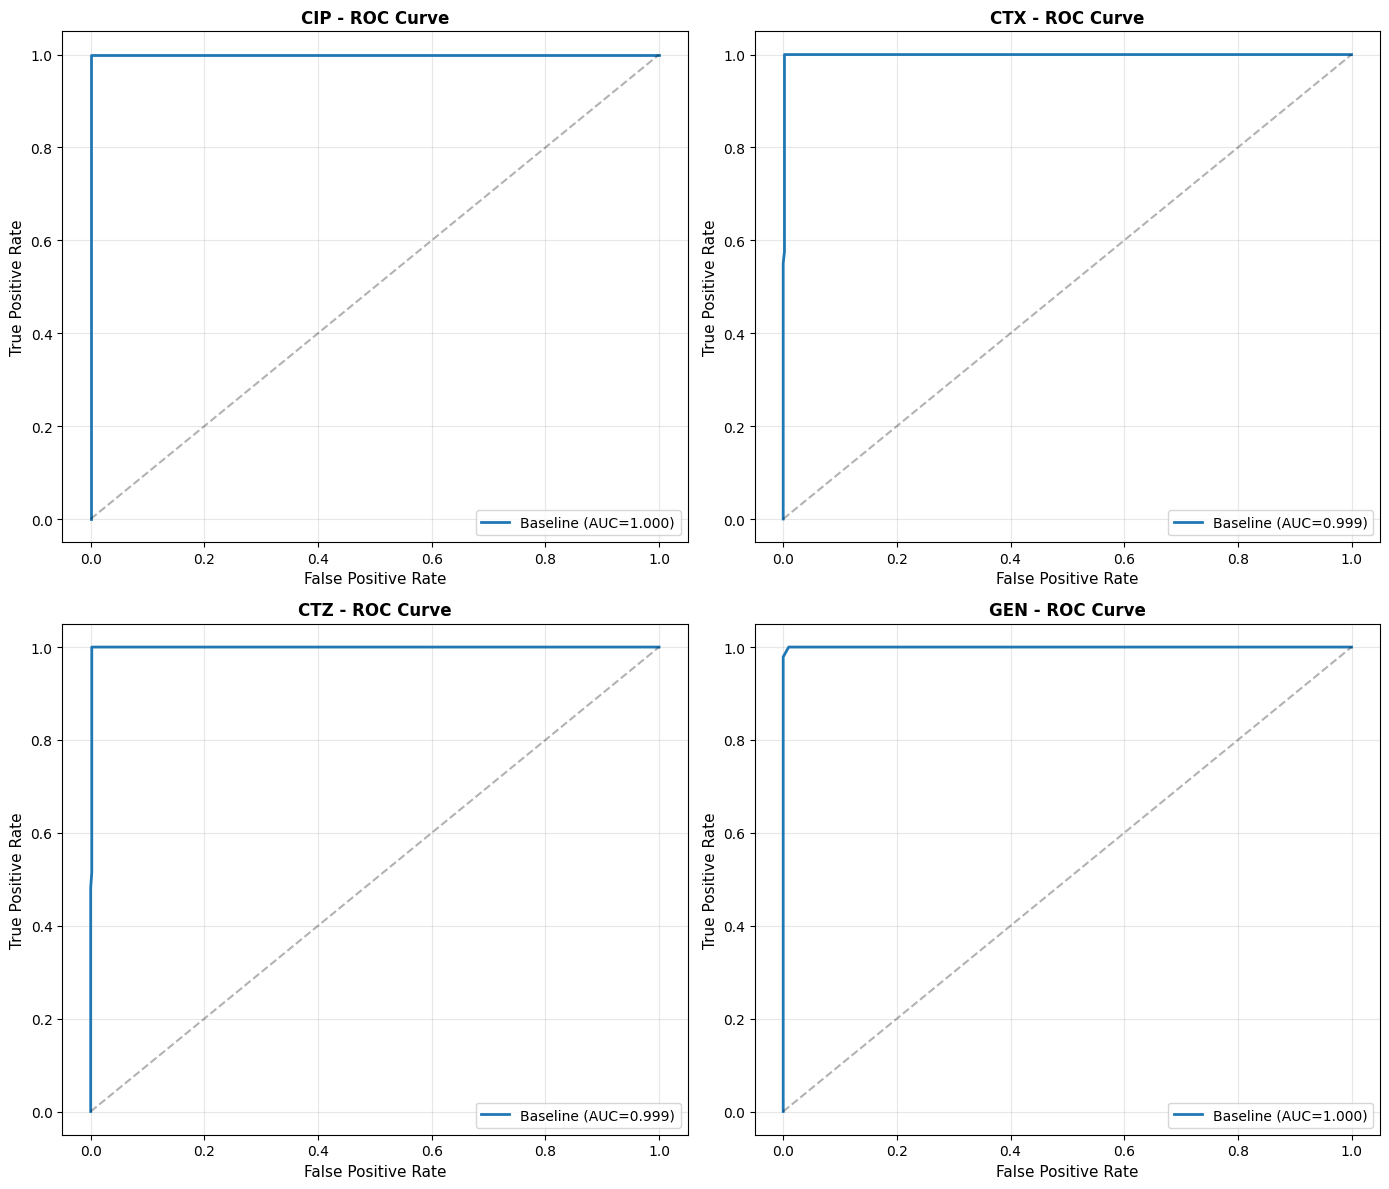

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, ab in enumerate(['CIP', 'CTX', 'CTZ', 'GEN']):
    y = pheno[ab].values

    #get predictions
    rf_baseline = RandomForestClassifier(**BASELINE_PARAMS)
    rf_baseline.fit(X, y)
    pred_baseline = rf_baseline.predict_proba(X)[:, 1]

    fpr_base, tpr_base, _ = roc_curve(y, pred_baseline)
    auc_base = roc_auc_score(y, pred_baseline)

    axes[idx].plot(fpr_base, tpr_base, label=f'Baseline (AUC={auc_base:.3f})', linewidth=2)
    axes[idx].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[idx].set_xlabel('False Positive Rate', fontsize=11)
    axes[idx].set_ylabel('True Positive Rate', fontsize=11)
    axes[idx].set_title(f'{ab} - ROC Curve', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='lower right')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/ML-iAMR_Recreation/05_evaluation/results/{EXPERIMENT_ID}_roc_curves.png', dpi=300, bbox_inches='tight')
print(f"ROC curves saved: {EXPERIMENT_ID}_roc_curves.png")